In [16]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import read_csv
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ['full', 'api_only_full', 'api_only_name', 'file', 'network', 'registry']
RUN_NAME = "fields multiclass"
INFOLDER = "out_fields_multiclass"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

VOCAB = 50000
SEQ_LEN = 512

LIMIT = "full"
from nebula.constants import SPEAKEASY_LABELMAP as LABEL_MAP
REVERSE_LABELMAP = {v: k for k, v in LABEL_MAP.items()}

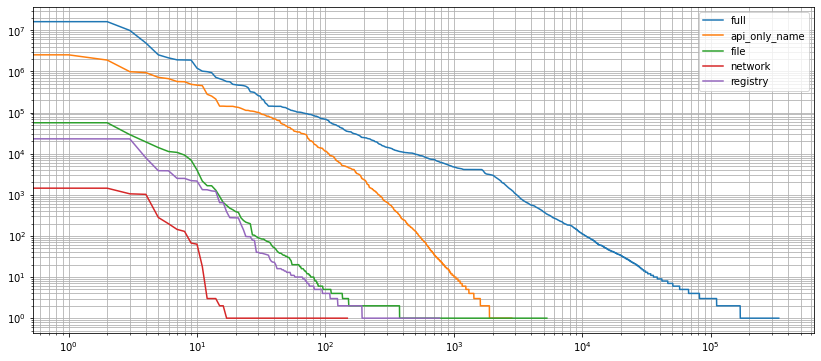

In [10]:
counters = {}

fig, ax = plt.subplots(1,1, figsize=(14,6))

for run_type in RUN_TYPES:
    if run_type in ["api_only_full"]:
        # for some reason "api_only_full" has practically the same token counts as "api_file_network_registry"
        # it might be related to pre-processing that strips all the punctuation?
        # i.e. text = text.translate(str.maketrans('', '', string.punctuation))
        continue
    counter_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_counter.json")
    with open(counter_file) as f:
        counter = json.load(f)
    # sort by value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)}
    counters[run_type] = counter
    # plot all token counts
    ax.plot(list(counter.values()), label=run_type)
ax.set_yscale("log")
ax.set_xscale("log")
# scale all ticks
ax.grid(True, which="both")
_ = ax.legend()

In [11]:
models = defaultdict(dict)
for run_type in RUN_TYPES:
    nebula_vocab_file = os.path.join(INFOLDER, f"{run_type}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

    with open(nebula_vocab_file) as f:
        nebula_vocab = json.load(f)
    
    models[run_type]['class'] = TransformerEncoderChunks
    models[run_type]['config'] = {
        "vocab_size": len(nebula_vocab),
        "maxlen": SEQ_LEN,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 8, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for run_type in RUN_TYPES:
    folder = os.path.join(INFOLDER, f"cv_{run_type}_limNone_{RUN_END_FILTER}")
    key = run_type
    print(f"[*] In process: {key}")

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[*] In process: full
[*] In process: api_only_full
[*] In process: api_only_name
[*] In process: file
[*] In process: network
[*] In process: registry


clean
                 0.0001       AUC        F1    Recall  Precision  Accuracy
full           0.003719  0.976081  0.962135  0.979121   0.945822  0.975015
api_only_full  0.003483  0.975769  0.960989  0.980223   0.942554  0.974201
api_only_name  0.001413  0.931807  0.899334  0.929757   0.870949  0.932533
file           0.000100  0.500000  0.437818  1.000000   0.280265  0.280265
network        0.000100  0.500000  0.437818  1.000000   0.280265  0.280265
registry       0.000100  0.500000  0.437818  1.000000   0.280265  0.280265

backdoor
                 0.0001       AUC        F1    Recall  Precision  Accuracy
full           0.030134  0.915279  0.891639  0.837266   0.957841  0.970562
api_only_full  0.040220  0.908017  0.890691  0.819476   0.976726  0.970825
api_only_name  0.010752  0.871964  0.836899  0.751472   0.944404  0.957439
file           0.000100  0.500000  0.000000  0.000000   0.000000  0.878568
network        0.000100  0.500000  0.000000  0.000000   0.000000  0.878568
registry 

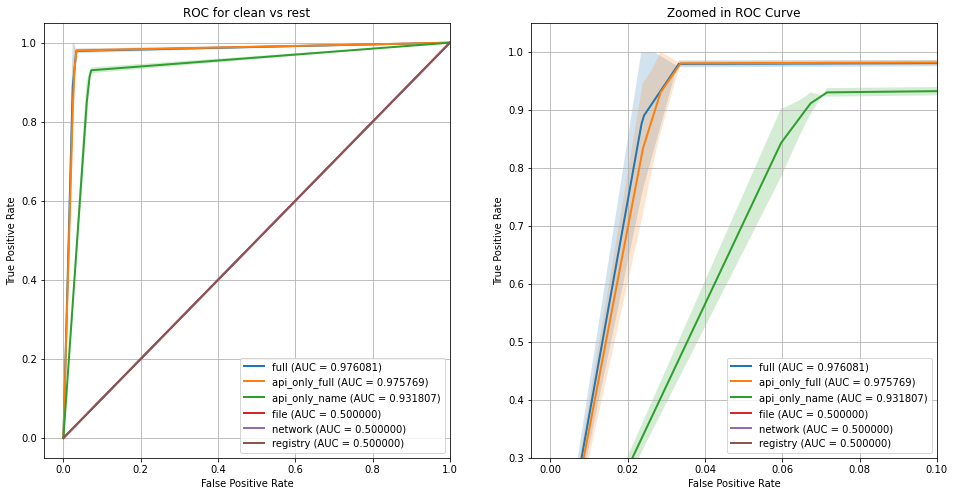

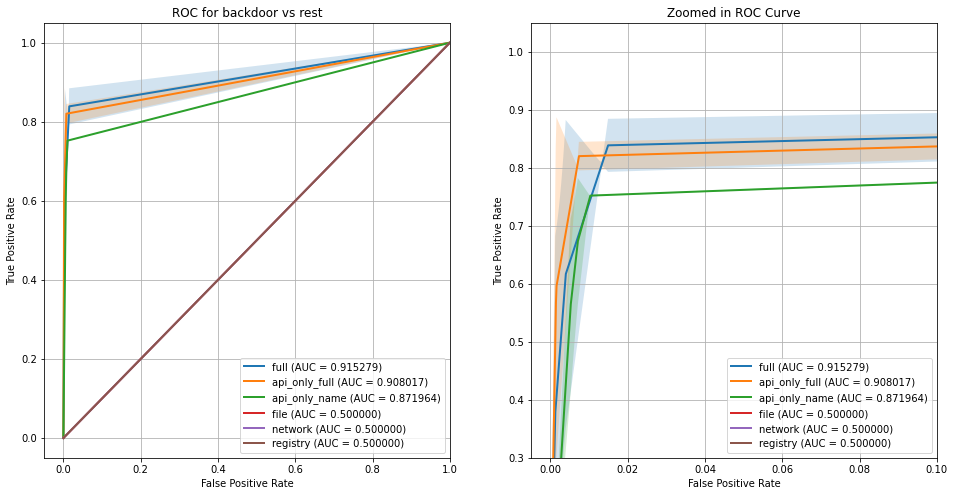

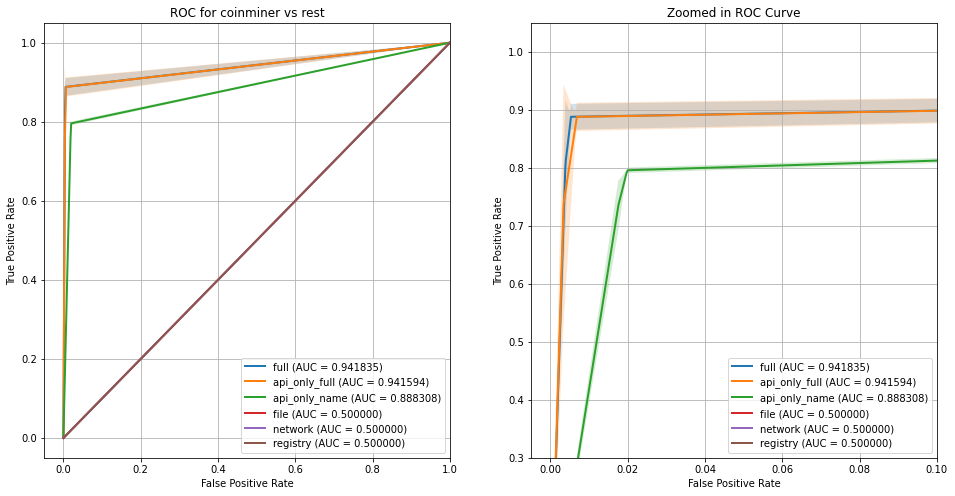

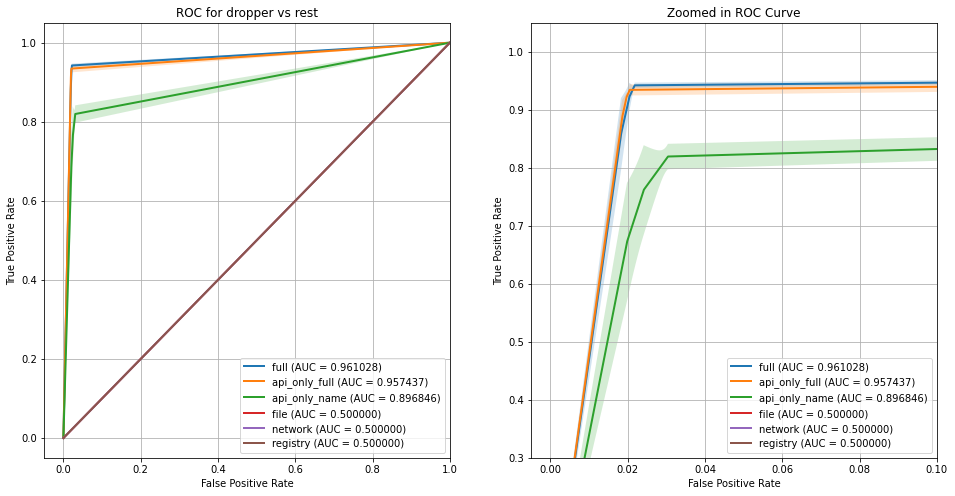

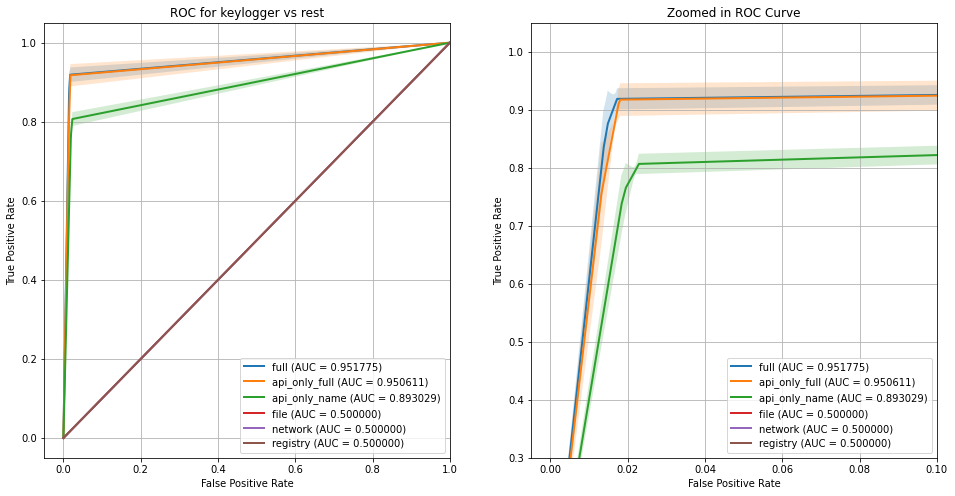

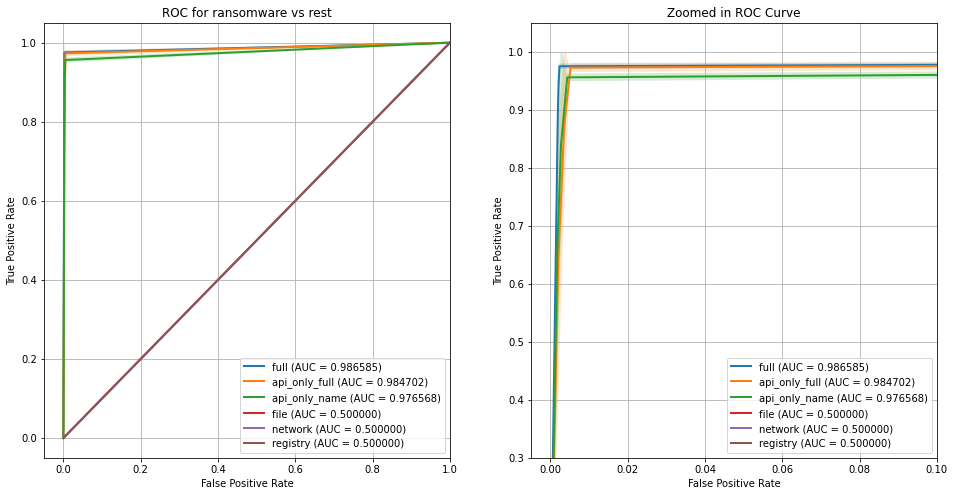

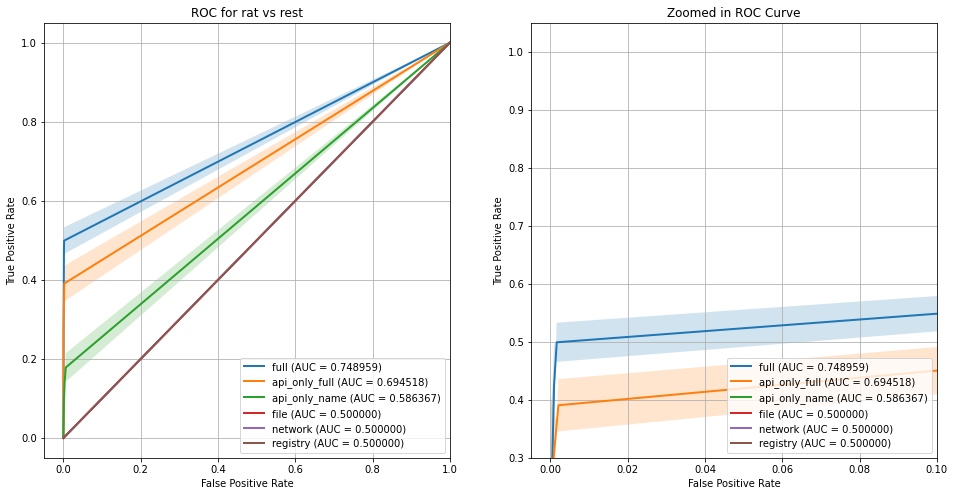

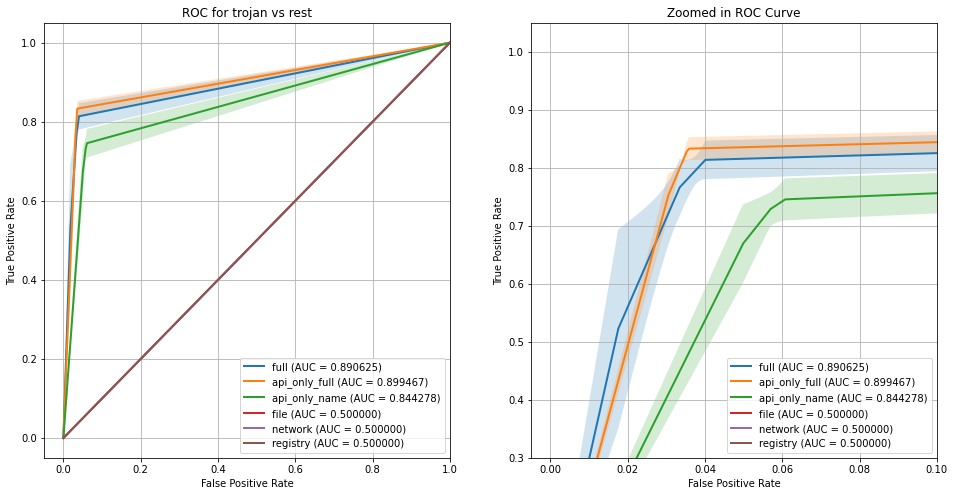

In [14]:
for selected_label in LABEL_MAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])
    print()

## Test set ROCs

In [17]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for run_type in RUN_TYPES:
    folder = os.path.join(INFOLDER, f"cv_{run_type}_limNone_{RUN_END_FILTER}")
    key = run_type

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        
        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

[*] In process: full
[*] Running ROC for split: 0
Evaluating full_split_0 | Size: 5397704...


100%|██████████| 182/182 [00:05<00:00, 33.75it/s]


[*] Running ROC for split: 1
Evaluating full_split_1 | Size: 5397704...


100%|██████████| 182/182 [00:05<00:00, 34.89it/s]


[*] Running ROC for split: 2
Evaluating full_split_2 | Size: 5397704...


100%|██████████| 182/182 [00:05<00:00, 32.68it/s]


[*] In process: api_only_full
[*] Running ROC for split: 0
Evaluating api_only_full_split_0 | Size: 5397704...


100%|██████████| 182/182 [00:06<00:00, 28.74it/s]


[*] Running ROC for split: 1
Evaluating api_only_full_split_1 | Size: 5397704...


100%|██████████| 182/182 [00:06<00:00, 28.45it/s]


[*] Running ROC for split: 2
Evaluating api_only_full_split_2 | Size: 5397704...


100%|██████████| 182/182 [00:06<00:00, 28.85it/s]


[*] In process: api_only_name
[*] Running ROC for split: 0
Evaluating api_only_name_split_0 | Size: 2378504...


100%|██████████| 182/182 [00:05<00:00, 30.65it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 1
Evaluating api_only_name_split_1 | Size: 2378504...


100%|██████████| 182/182 [00:05<00:00, 32.10it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 2
Evaluating api_only_name_split_2 | Size: 2378504...


100%|██████████| 182/182 [00:05<00:00, 32.32it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] In process: file
[*] Running ROC for split: 0
Evaluating file_split_0 | Size: 2536776...


100%|██████████| 182/182 [00:05<00:00, 32.63it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 1
Evaluating file_split_1 | Size: 2536776...


100%|██████████| 182/182 [00:05<00:00, 32.53it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 2
Evaluating file_split_2 | Size: 2536776...


100%|██████████| 182/182 [00:05<00:00, 31.74it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] In process: network
[*] Running ROC for split: 0
Evaluating network_split_0 | Size: 2207432...


100%|██████████| 182/182 [00:05<00:00, 31.50it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 1
Evaluating network_split_1 | Size: 2207432...


100%|██████████| 182/182 [00:05<00:00, 31.41it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 2
Evaluating network_split_2 | Size: 2207432...


100%|██████████| 182/182 [00:05<00:00, 31.18it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] In process: registry
[*] Running ROC for split: 0
Evaluating registry_split_0 | Size: 2247496...


100%|██████████| 182/182 [00:05<00:00, 31.87it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 1
Evaluating registry_split_1 | Size: 2247496...


100%|██████████| 182/182 [00:05<00:00, 32.18it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

[*] Running ROC for split: 2
Evaluating registry_split_2 | Size: 2247496...


100%|██████████| 182/182 [00:05<00:00, 32.08it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification

clean
                 0.0001       AUC        F1    Recall  Precision  Accuracy
full           0.000392  0.864400  0.861788  0.982301   0.767904  0.854924
api_only_full  0.000260  0.801134  0.808642  0.979594   0.688512  0.786791
api_only_name  0.000110  0.537498  0.632980  0.924121   0.483071  0.506425
file           0.000100  0.499892  0.628953  0.995211   0.459761  0.460083
network        0.000100  0.500563  0.629453  0.996127   0.460098  0.460734
registry       0.000100  0.500000  0.629963  1.000000   0.459815  0.459815
backdoor
                 0.0001       AUC        F1    Recall  Precision  Accuracy
full           0.015638  0.874571  0.820591  0.761168   0.895276  0.962697
api_only_full  0.002745  0.758923  0.634004  0.537457   0.774891  0.931024
api_only_name  0.000534  0.500225  0.023032  0.013230   0.287942  0.878670
file           0.000100  0.500000  0.000000  0.000000   0.000000  0.888551
network        0.000100  0.500000  0.000000  0.000000   0.000000  0.888551
registry  

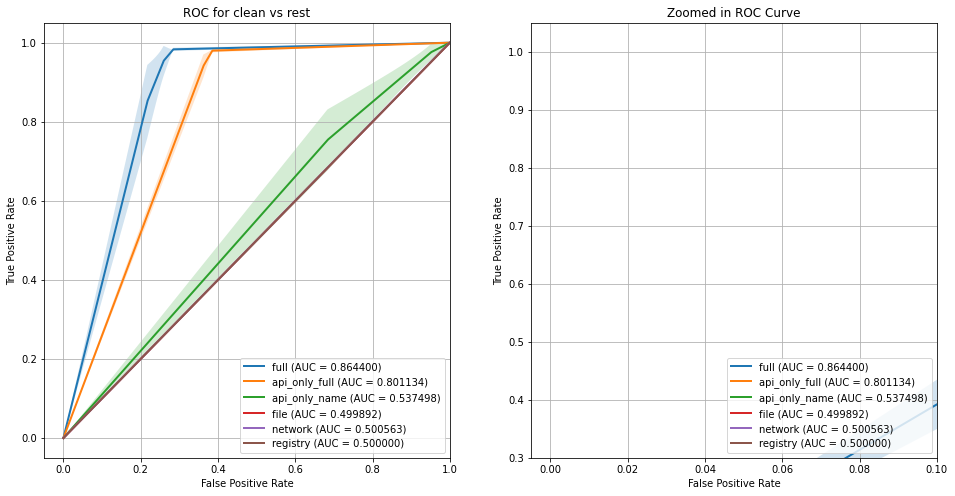

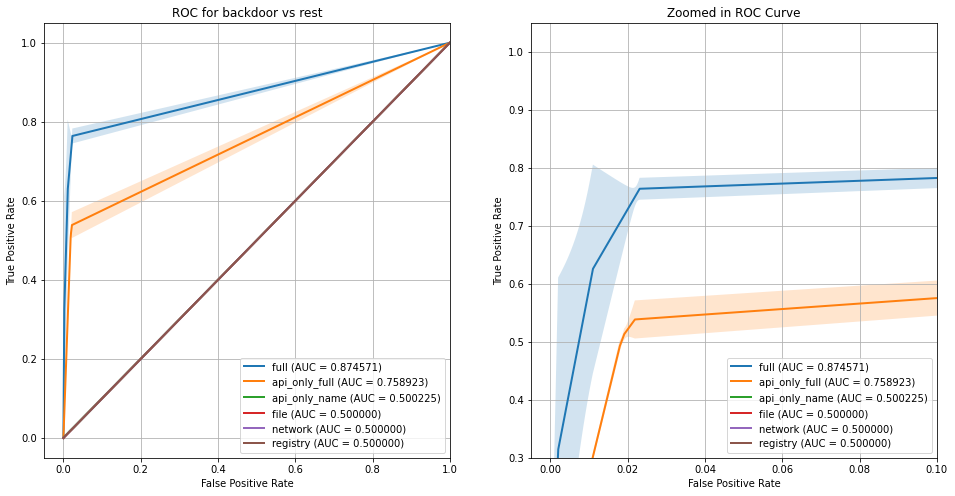

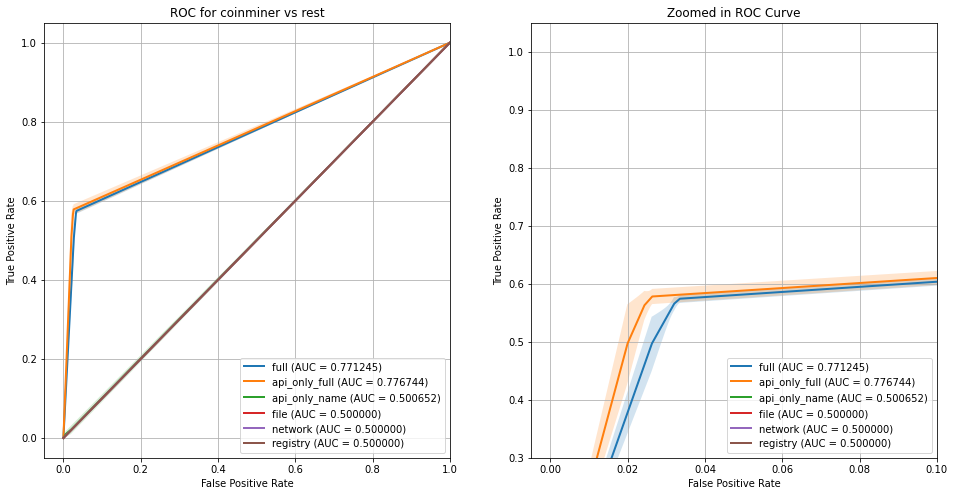

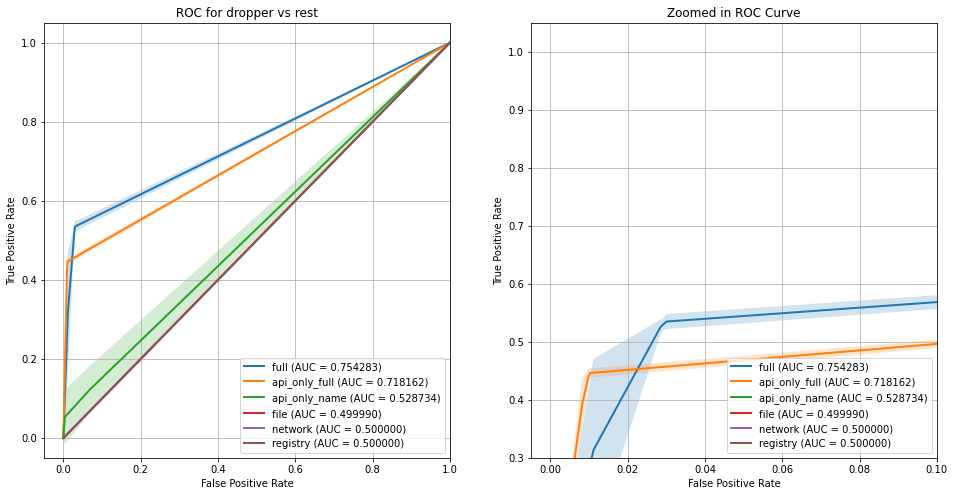

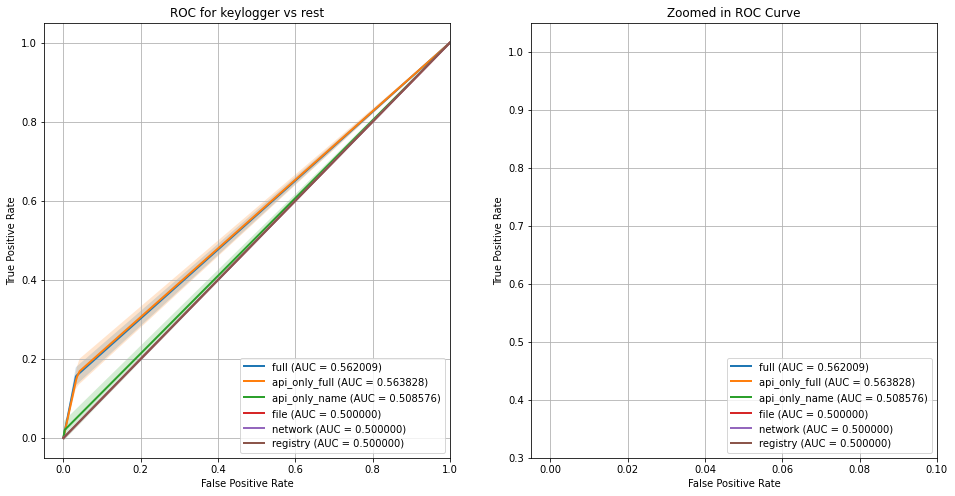

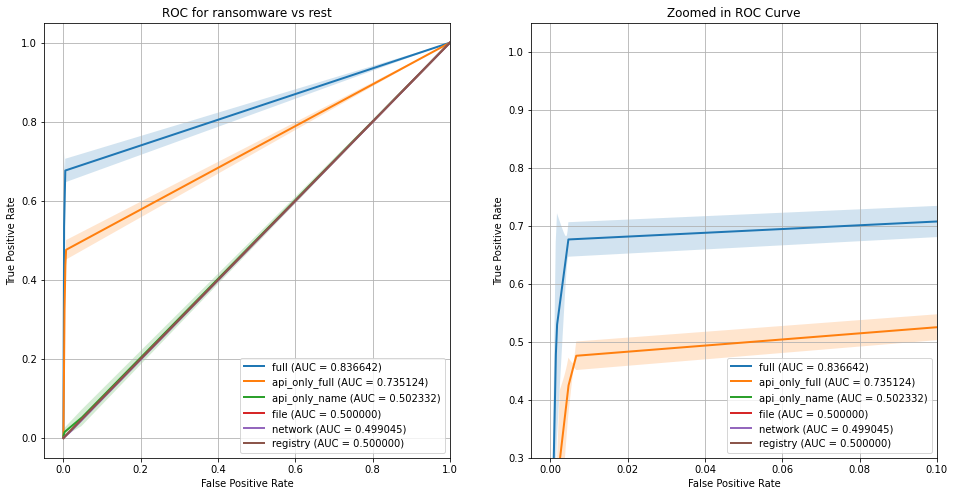

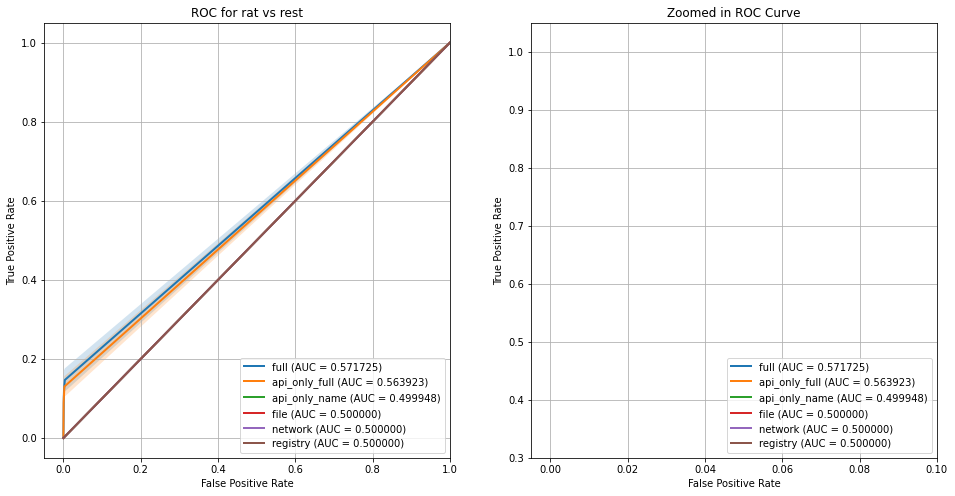

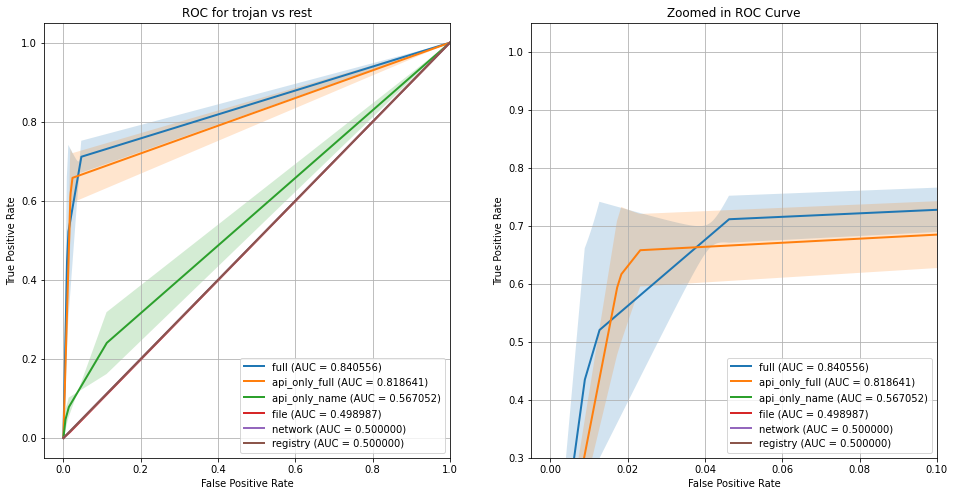

In [18]:
for selected_label in LABEL_MAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    # suptitle to refer label
    axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])